# Optical Flow Trajectory Prediction

## Imports and Utility

In [1]:
import os

import numpy as np
import numpy.linalg as npl
import pandas as pd
import scipy
import sklearn
from sklearnex import patch_sklearn
import cv2 as cv
from typing import List, Tuple
from PIL import Image
import matplotlib.pyplot as plt
# import bokeh
# from bokeh.plotting import figure, show
# from bokeh.io import output_notebook

import torch

patch_sklearn()

%matplotlib inline
#Import yolov5 for object detection/tracking
from yolov5 import YOLOv5
PROJECT_DEBUG = True
%matplotlib inline

#Switch to CUDA if we have a GPU we can use
yolo_pre_train_model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

%matplotlib inline

# output_notebook()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Using cache found in C:\Users\Nikhi/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-5-4 Python-3.12.1 torch-2.3.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [2]:
#YOLO requires colors in images
def load_image_color(filepath: str) -> np.ndarray:
    im = cv.imread(filepath, cv.IMREAD_COLOR)
    if im is None:
        raise FileNotFoundError(f"Image not found at {filepath}")
    im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
    return im.astype(np.float32) / 255.0

def load_image_gray(filepath: str) -> np.ndarray:
    img = cv.imread(filepath, cv.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Image not found at {filepath}")
    mi = np.min(img)
    ma = np.max(img)
    return img / float(ma - mi)

def parse_meta(folder: str) -> Tuple[int, int, int, int]:
    supported_types = ['png', 'txt', 'jpg', 'jpeg']
    all_files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    supported_files = [f for f in all_files if any([f.endswith(end) for end in supported_types])]

    num_frames: int = 0
    frame_width: int = 0
    frame_height: int = 0
    frame_rate: int = 0

    if 'meta.txt' not in supported_files:
        raise FileNotFoundError(f'meta.txt not found in {folder}')
    else:
        with open(os.path.join(folder, 'meta.txt'), 'r') as f:
            lines = f.readlines()
            if len(lines) < 4:
                raise Exception(f'Not enough lines in meta.txt')
            frame_width, frame_height, num_frames, frame_rate = (int(line) for line in lines[:4])

    return (frame_width, frame_height, num_frames, frame_rate)

def load_image_sequence(folder: str, color: bool = False) -> np.ndarray:
    supported_types = ['png', 'txt', 'jpg', 'jpeg']
    all_files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    supported_files = [f for f in all_files if any([f.endswith(end) for end in supported_types])]
    unsupported_files = [f for f in all_files if f not in supported_files]

    if PROJECT_DEBUG:
        if unsupported_files != []:
            print(f'Warning! Following files from {folder} are unsupported, ignoring: {", ".join(unsupported_files)}')

    num_frames: int = 0
    frame_width: int = 0
    frame_height: int = 0
    frame_rate: int = 0

    frame_width, frame_height, num_frames, frame_rate = parse_meta(folder)

    if num_frames == 0:
        raise Exception(f'Folder must have at least one frame')
    if frame_width == 0 or frame_height == 0:
        raise Exception(f'Dimensions must result in non-zero number of pixels')

    image_files = [f for f in all_files if f.endswith('png') or f.endswith('jpg')]

    if len(image_files) < num_frames:
        raise FileNotFoundError(f'Not enough files for number of frames specified in meta.txt ({len(image_files)} < {num_frames})')

    if not color:
        video = np.zeros((num_frames, frame_height, frame_width))
    else:
        video = np.zeros((num_frames, frame_height, frame_width, 3), dtype=np.float32)

    load_function = load_image_color if color else load_image_gray

    if len(image_files) == 0:
        raise FileNotFoundError()

    for f_no, img_file in enumerate(image_files):
        video[f_no] = load_function(os.path.join(folder, img_file))

    if video is None:
        print("Failed to load")

    return video



## Derivatives

In [10]:
convolve = lambda img, flt: scipy.ndimage.convolve(img, flt, mode='nearest')

def horiz_deriv(video: np.ndarray):
    filt = np.array([
        [[-1, 0, 1],
         [-2, 0, 2],
         [-1, 0, 1]],
        [[-2, 0, 2],
         [-4, 0, 4],
         [-2, 0, 2]],
        [[-1, 0, 1],
         [-2, 0, 2],
         [-1, 0, 1],]
    ])

    return convolve(video, filt)

def vert_deriv(video: np.ndarray):
    filt = np.array([
        [[-1, -2, -1],
         [0, 0, 0],
         [1, 2, 1]],
        [[-2, -4, -2],
         [0, 0, 0],
         [2, 4, 2]],
        [[-1, -2, -1],
         [0, 0, 0],
         [1, 2, 1]],
    ])

    return convolve(video, filt)

def time_deriv(video: np.ndarray):
    filt = np.array([
        [[-1, -2, -1],
         [-2, -4, -2],
         [-1, -2, -1]],
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
        [[1, 2, 1],
         [2, 4, 2],
         [1, 2, 1]],
    ])

    return convolve(video, filt)

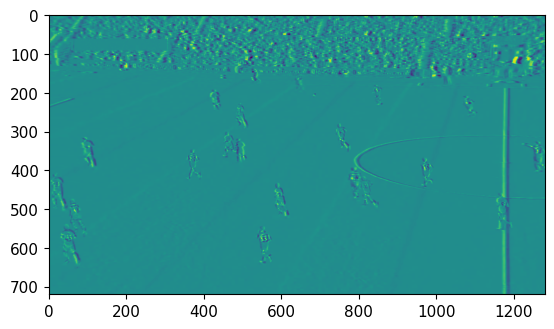

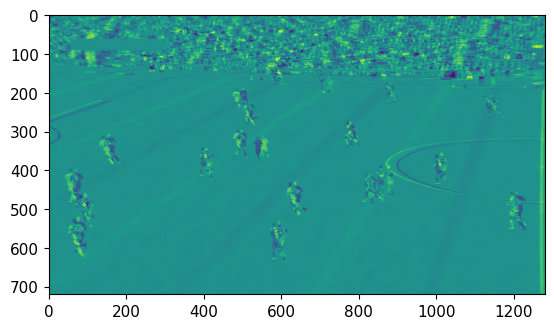

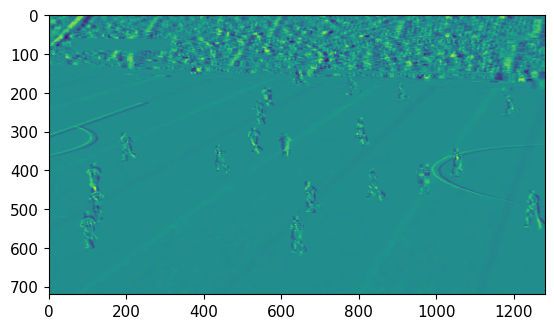

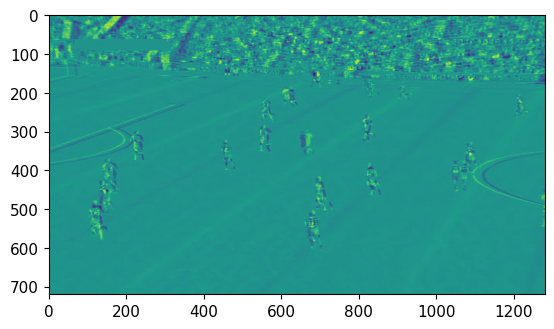

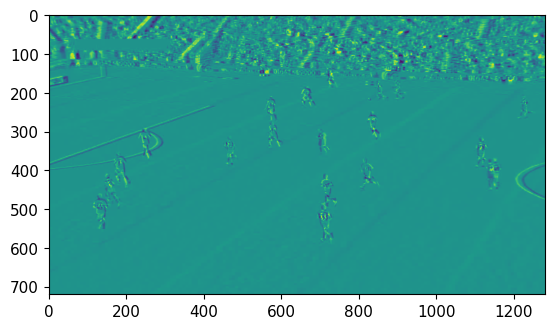

In [12]:
folder = './soccer/'
# folder = './blender_tests/throw1/mist/'

video = load_image_sequence(folder)
frame_width, frame_height, num_frames, frame_rate = parse_meta(folder)

I_x = horiz_deriv(video)
I_y = vert_deriv(video)
I_t = time_deriv(video)

for deriv in I_t[::10]:
    plt.figure()
    plt.imshow(deriv)

## Feature Detection

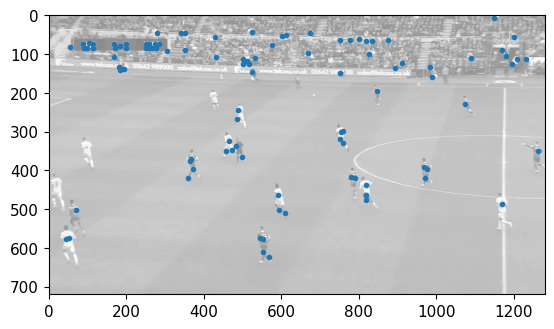

In [13]:
first_frame = video[0]
mask1 = np.zeros_like(first_frame)
mask1[:, 650:850] = 1
mask2 = np.zeros_like(first_frame)
mask2[100:200, :] = 1

mask = np.logical_and(mask1, mask2).astype(np.uint8)

track_points = cv.goodFeaturesToTrack(
    first_frame.astype('f4'),
    maxCorners=100,
    qualityLevel=0.1,
    minDistance=7,
    blockSize=7,
    mask=None)

plt.figure()
plt.imshow(first_frame, cmap='gray', vmin=-1, vmax=1)
plt.scatter(track_points[:, 0, 0], track_points[:, 0, 1], marker='.')


## Tracking

In [20]:
WINDOW_SIZE = 5

def get_window_coordinates(center: Tuple[int, int], win_size: int, lower_clamp=True) -> List[Tuple[int, int]]:
    xs = [x for x in range(center[0] - win_size // 2, center[0] + win_size // 2 + 1) if (not lower_clamp) or (x >= 0)]
    ys = [y for y in range(center[1] - win_size // 2, center[1] + win_size // 2 + 1) if (not lower_clamp) or (y >= 0)]

    coords = [(x, y) for x in xs for y in ys]
    return coords

frame1 = video[0]
frame2 = video[1]

u_field = np.zeros_like(frame1)
v_field = np.zeros_like(frame1)
zeroes = np.zeros_like(frame1)

l = 0.01

# while True:
for i in range(100):
    calculation = (I_x[0] * u_field + I_y[0] * v_field + I_t[0]) / ((1 / l) + I_x[0] ** 2 + I_y[0] ** 2)
    u_field -= calculation * I_x[0]
    v_field -= calculation * I_y[0]

x, y = np.meshgrid(np.arange(frame1.shape[0]), np.arange(frame1.shape[1]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


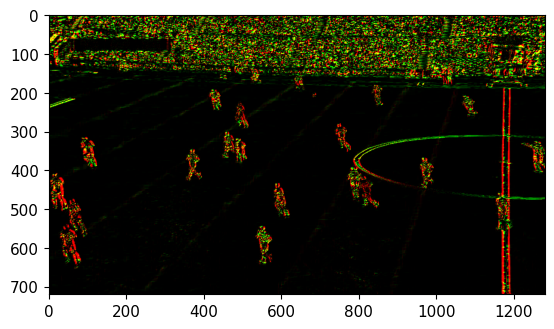

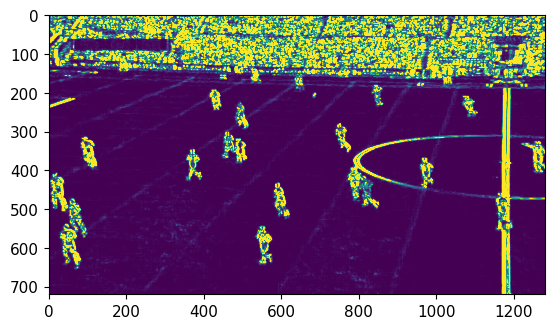

In [21]:
plt.figure()
plt.imshow(np.stack((u_field, v_field, zeroes), axis=2), vmin=-1, vmax=1)

plt.figure()
plt.imshow(
    np.sqrt((u_field ** 2) + (v_field ** 2)), vmin=0, vmax=1
     )

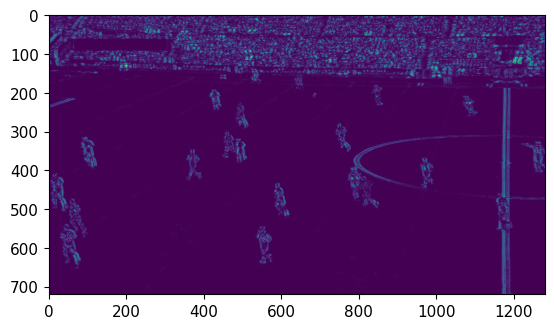

In [41]:
# normalizing motion
motion = np.sqrt((u_field ** 2) + (v_field ** 2))
motion_min, motion_max = np.min(motion), np.max(motion)
motion_norm = motion / (motion_max - motion_min)

plt.figure()
plt.imshow(motion_norm, vmin=0, vmax=1)

## Motion-based masking

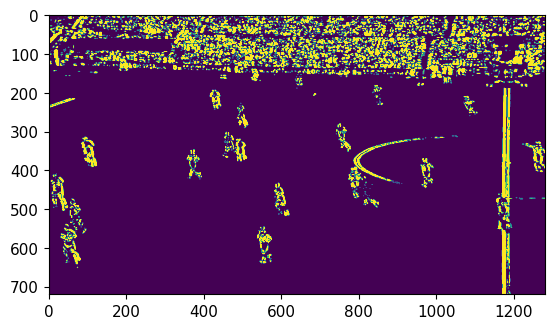

In [54]:
motion_thresh = 0.15
moving_pixels = motion_norm.copy()
moving_pixels[moving_pixels < motion_thresh] = 0

plt.figure()
plt.imshow(moving_pixels * 10, vmin=0, vmax=1)

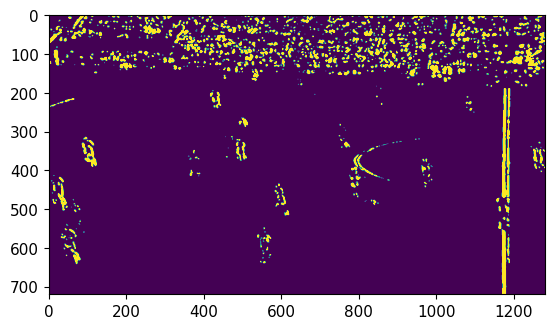

In [104]:
blurred_motion = cv.medianBlur(moving_pixels.astype('float32'), 5)
plt.imshow(blurred_motion * 10, vmin=0, vmax=1)

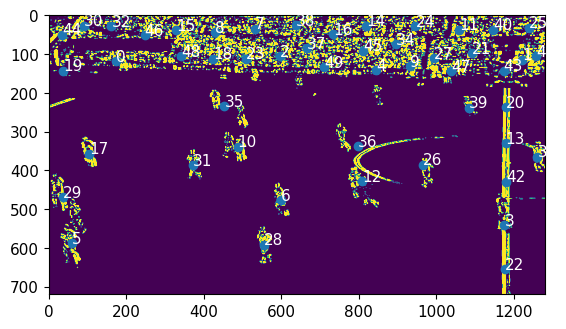

In [134]:
from sklearn.cluster import KMeans
from scipy.spatial import distance_matrix

valid_bb_indices = [[x, y]
              for x in np.arange(moving_pixels.shape[1]).astype('uint16')
              for y in np.arange(moving_pixels.shape[0]).astype('uint16')
              if moving_pixels[y, x]]

model = KMeans(n_clusters=50, init='k-means++', tol=0.1)
model.fit(valid_bb_indices)

plt.imshow(moving_pixels * 10, vmin=0, vmax=1)
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1])

[plt.annotate(f'{i}', model.cluster_centers_[i], c='white') for i in range(len(model.cluster_centers_))]

dist_mat_idx_centroid = distance_matrix(valid_bb_indices, model.cluster_centers_, p=1)

closest_clusters = np.argmin(dist_mat_idx_centroid, axis=1)

clusters = [[]] * len(model.cluster_centers_)
for i in closest_clusters:
    clusters[i] = np.unravel_index(np.argwhere(closest_clusters == i), shape=moving_pixels.shape)


In [135]:
clusters

[(array([[4],
         [4],
         [4],
         ...,
         [7],
         [7],
         [7]], dtype=int64),
  array([[157],
         [191],
         [345],
         ...,
         [324],
         [325],
         [326]], dtype=int64)),
 (array([[44],
         [45],
         [45],
         ...,
         [47],
         [47],
         [47]], dtype=int64),
  array([[194],
         [657],
         [658],
         ...,
         [560],
         [561],
         [562]], dtype=int64)),
 (array([[17],
         [17],
         [17],
         ...,
         [21],
         [21],
         [21]], dtype=int64),
  array([[1239],
         [1240],
         [1241],
         ...,
         [ 423],
         [ 424],
         [ 425]], dtype=int64)),
 (array([[40],
         [40],
         [40],
         ...,
         [45],
         [45],
         [45]], dtype=int64),
  array([[495],
         [496],
         [497],
         ...,
         [844],
         [845],
         [861]], dtype=int64)),
 (array([[25],
     

In [147]:
cluster_bounds = [[np.min(cluster[0]), np.min(cluster[1]), np.max(cluster[0]), np.max(cluster[1])] for cluster in clusters]
cluster_bounds

def draw_rect(bounds):
    tly, tlx, bry, brx = bounds
    plt.plot([tlx, brx, brx, tlx], [tly, tly, bry, bry], c='black')

plt.figure()
# plt.imshow(moving_pixels)
[draw_rect(bounds) for bounds in cluster_bounds]

KeyboardInterrupt: 

In [83]:
from scipy.cluster.hierarchy import DisjointSet

# [(topleftX, topleftY, botrightX, botright)]
valid_bb_indices = [[x, y]
              for x in np.arange(moving_pixels.shape[1]).astype('uint16')
              for y in np.arange(moving_pixels.shape[0]).astype('uint16')
              if moving_pixels[y, x]]
disjoint_set = DisjointSet(valid_bb_indices)

def get_neighbors(x, y, max_x, max_y):
    ns = [(x - 1, y),
          (x + 1, y),
          (x, y - 1),
          (x, y + 1)]

    valid_ns = []
    for n in ns:
        n_x, n_y = ns
        if n_x < 0 or n_x >= max_x or n_y < 0 or n_y >= max_y:
            continue
        valid_ns.append(ns)

    return ns

for i in range(len(disjoint_set.subsets())):
    subsets = disjoint_set.subsets()
    minx = min([x for x, y in subsets[i]])
    miny = max([y for x, y in subsets[i]])
    maxx = min([x for x, y in subsets[i]])
    maxy = max([y for x, y in subsets[i]])
    neighbors = get_neighbors(minx, miny, moving_pixels.shape[0], moving_pixels.shape[1])
    neighbors += get_neighbors(maxx, maxy, moving_pixels.shape[0], moving_pixels.shape[1])
    neighbors = [(nx, ny) for nx, ny in neighbors
                 if not (nx > minx and ny > miny and nx < maxx and ny < maxy) and
                    not disjoint_set.connected()]

valid_bb_indices[-10:]

[[1279, 351, 1279, 351],
 [1279, 353, 1279, 353],
 [1279, 388, 1279, 388],
 [1279, 391, 1279, 391],
 [1279, 392, 1279, 392],
 [1279, 393, 1279, 393],
 [1279, 394, 1279, 394],
 [1279, 395, 1279, 395],
 [1279, 396, 1279, 396],
 [1279, 473, 1279, 473]]

## Example Ball

In [ ]:
ball_pos = [20, 20]
ball_radius = 10
ball_vel = [20, 0]

grav = 10

def draw_ball():
    world = np.zeros((300, 400), dtype='float32')
    noise = np.random.random(size=(2)) * 10
    bx, by = ball_pos

    for py in range(300):
        for px in range(400):
            if (bx - px + noise[0]) ** 2 + (by - py + noise[1]) ** 2 < ball_radius ** 2:
                world[py, px] = 1

    return world

frames = []

for i in range(25):
    ball_vel[1] += grav

    ball_pos[0] += ball_vel[0]
    ball_pos[1] += ball_vel[1]

    if ball_pos[1] + ball_radius >= 300:
        ball_pos[1] = 300 - ball_radius
        ball_vel[1] *= -1

    frame = draw_ball()
    if frame[frame != 0].size > 0:
        frames.append(frame)

    plt.figure()
    plt.imshow(frames[-1], vmin=0, vmax=1)


## Ransac

In [18]:
from scipy.linalg import solve

def get_quad_eq(x1, y1, x2, y2, x3, y3):
    '''
    Adapted and modifed to get the unknowns for defining a parabola:
    http://stackoverflow.com/questions/717762/how-to-calculate-the-vertex-of-a-parabola-given-three-points
    '''

    # denom = (x1-x2) * (x1-x3) * (x2-x3)
    # A     = (x3 * (y2-y1) + x2 * (y1-y3) + x1 * (y3-y2)) / denom
    # B     = (x3*x3 * (y1-y2) + x2*x2 * (y3-y1) + x1*x1 * (y2-y3)) / denom
    # C     = (x2 * x3 * (x2-x3) * y1+x3 * x1 * (x3-x1) * y2+x1 * x2 * (x1-x2) * y3) / denom

    X = np.array([
        [x1 ** 2, x1, 1],
        [x2 ** 2, x2, 1],
        [x3 ** 2, x3, 1]
    ])

    y = np.array([y1, y2, y3]).T

    coeffs = solve(X, y)

    return coeffs

def calc_quad(coeffs, x):
    A, B, C = coeffs
    return A * x ** 2 + B * x + C

def get_lin_eq(x1, y1, x2, y2):
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1

    return m, b

def calc_lin(coeffs, x):
    m, b = coeffs
    return m * x + b

import random

def ransac_linear(xs, ys):
    points = list(zip(xs, ys))
    best_coeffs = None
    best_score = np.inf

    for i in range(100):
        rand_points = random.choices(points, k=2)
        m, b = get_lin_eq(*np.array(rand_points).flatten())

        predicted = np.array([calc_lin((m, b), x) for x in xs])
        score = (predicted ** 2 - np.array(ys) ** 2).sum()

        if score < best_score:
            best_score = score
            best_coeffs = m, b

    return best_coeffs

def ransac_quad(xs, ys):
    points = list(zip(xs, ys))
    best_coeffs = None
    best_score = np.inf

    for i in range(100):
        rand_points = random.sample(points, k=3)
        A, B, C = get_quad_eq(*np.array(rand_points).flatten())

        predicted = np.array([calc_quad((A, B, C), x) for x in xs])
        score = (predicted ** 2 - np.array(ys) ** 2).sum()

        if np.abs(score) < best_score:
            best_score = np.abs(score)
            best_coeffs = A, B, C

    return best_coeffs


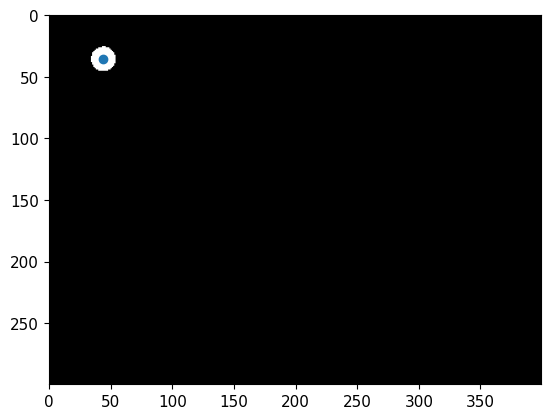

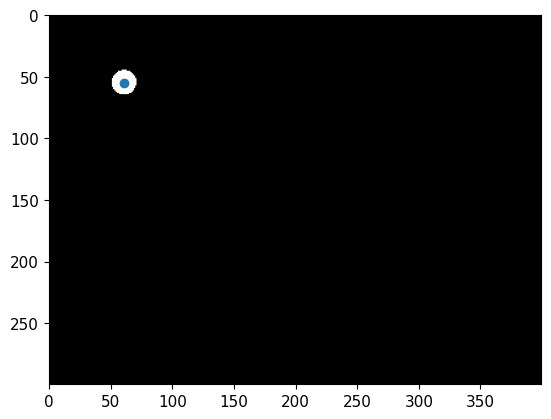

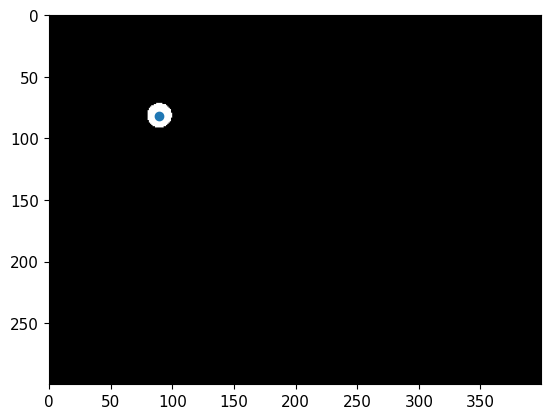

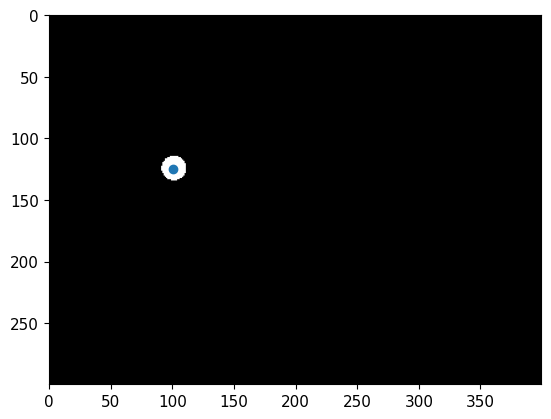

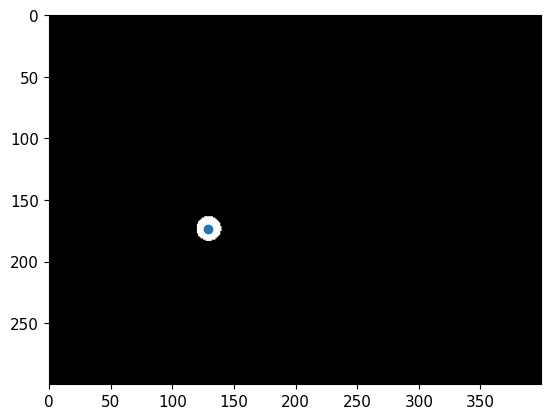

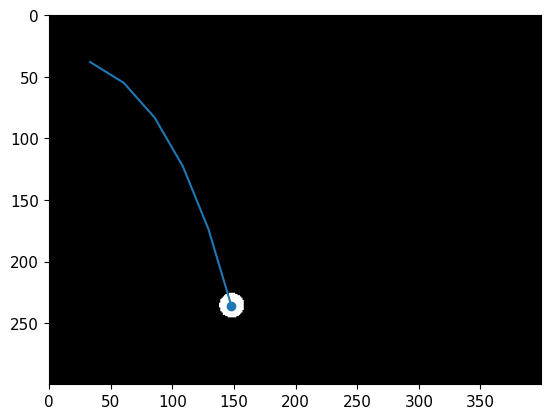

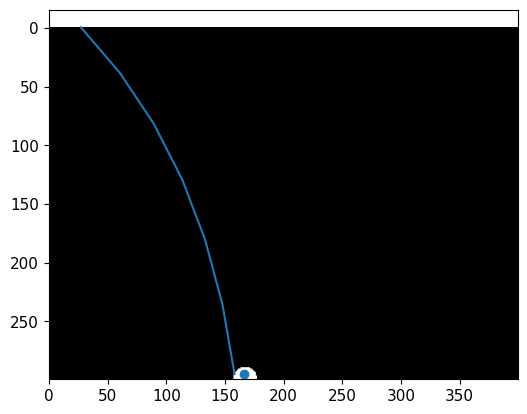

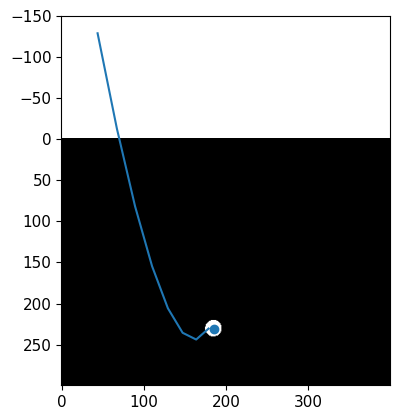

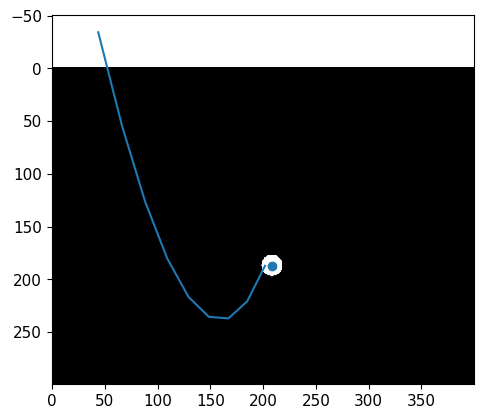

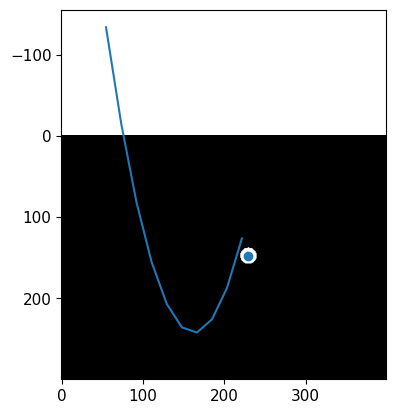

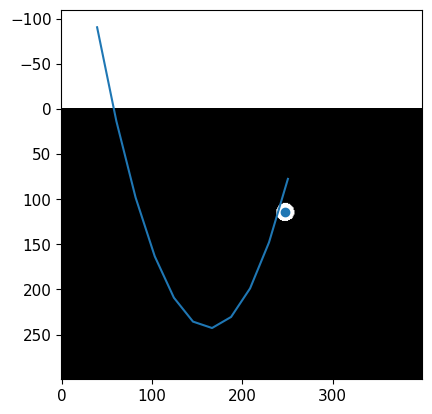

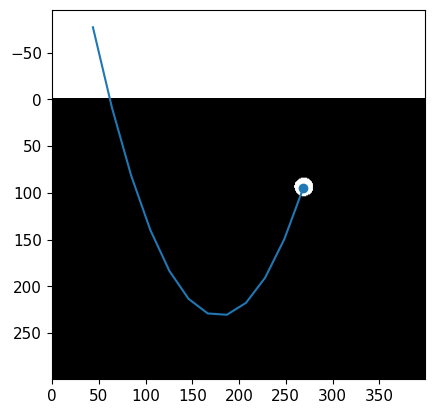

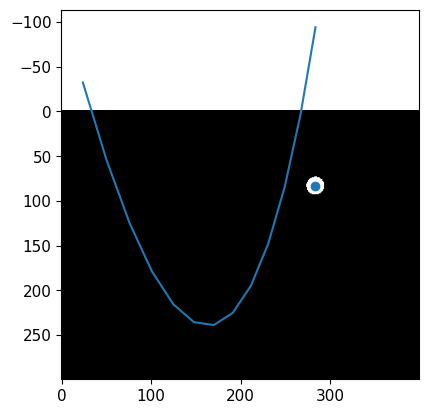

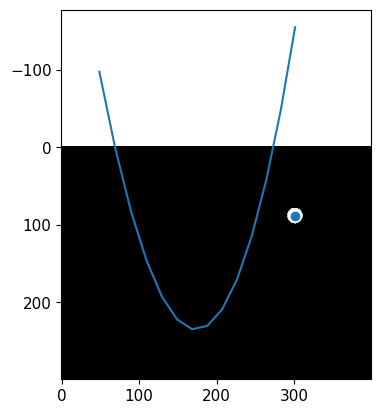

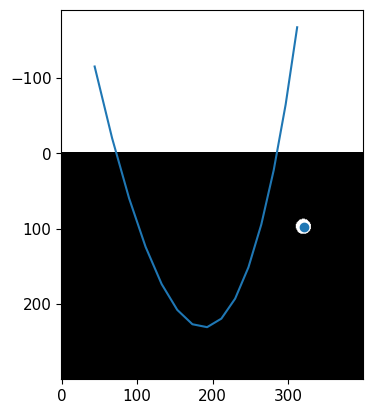

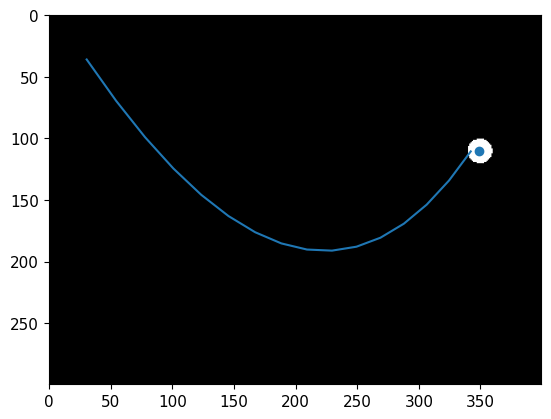

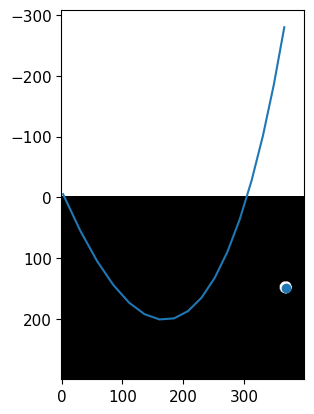

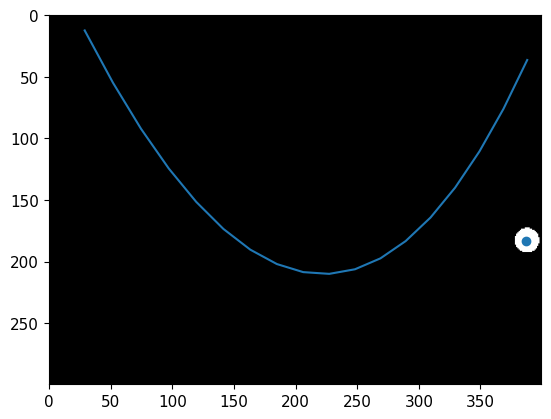

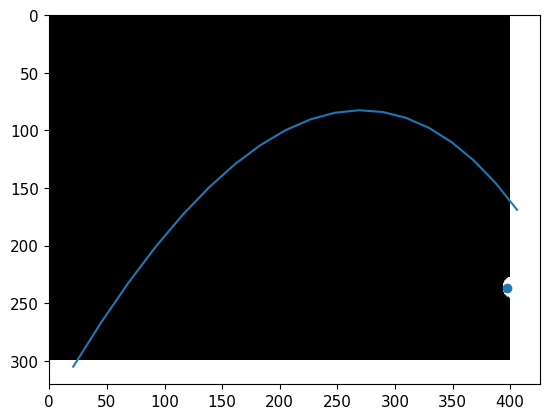

In [31]:
from sklearn.linear_model import LinearRegression, RANSACRegressor

detected_points = []
for t, frame in enumerate(frames):
    avg = np.mean(np.argwhere(frame != 0), axis=0)
    detected_points.append(avg)

    plt.figure()
    plt.imshow(frame, cmap='grey')
    plt.scatter([avg[1]], [avg[0]])

    if t < 5:
        continue

    ts = np.arange(0, t + 1)
    xs = [x for (x,y) in detected_points]
    ys = [y for (x,y) in detected_points]

    x_coeffs = ransac_quad(ts, xs)
    y_coeffs = ransac_quad(ts, ys)

    sample_ts = np.arange(0, 100)
    predicted_xs = [calc_quad(x_coeffs, t) for t in ts]
    predicted_ys = [calc_quad(y_coeffs, t) for t in ts]
    plt.plot(predicted_ys, predicted_xs)

